# Developing `make_ww3_wind_file` Worker

Code experiments and verification for the `make_ww3_wind_file` worker.

wwatch3 requires the wind forcing file that is input to `ww3_prnc`
to have a structure similar this ocean currents file:

```
netcdf GSL5km_2009_CUR {
dimensions:
    longitude = 150 ;
    latitude = 236 ;
    time = UNLIMITED ; // (8760 currently)
variables:
    double time(time) ;
        time:long_name = "Time" ;
        time:time_origin = "2009-01-01 01:00:00" ;
        time:delta_t = "0000-00-00 01:00:00" ;
        time:units = "days since 2009-01-01T01:00:00Z" ;
    double latitude(latitude, longitude) ;
        latitude:long_name = "Latitude" ;
        latitude:units = "degrees_north" ;
    double longitude(latitude, longitude) ;
        longitude:long_name = "Longitude" ;
        longitude:units = "degrees_east" ;
    double uas(time, latitude, longitude) ;
        uas:standard_name = "uas" ;
        uas:long_name = "East component of current" ;
        uas:units = "m s-1" ;
    double vas(time, latitude, longitude) ;
        vas:standard_name = "vas" ;
        vas:long_name = "North component of current" ;
        vas:units = "m s-1" ;

```
(Example courtesy of Caroline Sevigny at Université du Québec à Rimouski)

The worker needs to transform the `time_counter`,
`nav_lon`,
`nav_lat`,
`u_wind`,
and `v_wind` variable from files like

`/results/forcing/atmospheric/GEM2.5/operational/ops_y2017m03d17.nc`

to produce an netCDF4 file with a structure similar to above that `ww3_prnc` will accept.

It turns out that `xarray` makes it quite easy to produce such a file.

In [1]:
import arrow
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
%matplotlib inline

In [3]:
hrdps = xr.open_dataset('/results/forcing/atmospheric/GEM2.5/operational/fcst/ops_y2017m04d06.nc')
hrdps

<xarray.Dataset>
Dimensions:       (time_counter: 24, x: 256, y: 266)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2017-04-06 ...
  * x             (x) float64 0.0 2.5e+03 5e+03 7.5e+03 1e+04 1.25e+04 ...
  * y             (y) float64 0.0 2.5e+03 5e+03 7.5e+03 1e+04 1.25e+04 ...
Data variables:
    atmpres       (time_counter, y, x) float64 1.011e+05 1.011e+05 1.011e+05 ...
    nav_lat       (y, x) float64 45.66 45.67 45.67 45.68 45.68 45.69 45.69 ...
    nav_lon       (y, x) float64 233.0 233.0 233.1 233.1 233.1 233.2 233.2 ...
    precip        (time_counter, y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    qair          (time_counter, y, x) float64 0.005921 0.005933 0.005948 ...
    solar         (time_counter, y, x) float64 131.8 120.7 120.7 120.7 131.8 ...
    tair          (time_counter, y, x) float64 282.3 282.3 282.3 282.3 282.3 ...
    therm_rad     (time_counter, y, x) float64 307.7 307.7 313.3 307.7 307.7 ...
    u_wind        (time_counter, y, x) float64 -2

We need to create a new dataset with:

* the `time_counter` coordinate renamed to `time` because that is the coordinate/dimension name that `ww3_prnc` expects
* a `latitude` coordinate derived from the `nav_lat` variable because that is one of the variable names that `ww3_prnc` expects
* a `longitude` coordinate derived from the `nav_lon` variable because that is one of the variable names that `ww3_prnc` expects
* a `u_wind` variable with its `time_counter` coordinate renamed to `time`
* a `v_wind` variable with its `time_counter` coordinate renamed to `time`

In [5]:
ds = xr.Dataset(
    data_vars={
        'u_wind': hrdps.u_wind.rename({'time_counter': 'time'}),
        'v_wind': hrdps.v_wind.rename({'time_counter': 'time'}),
    },
    coords={
        'time': hrdps.time_counter.rename('time').rename({'time_counter': 'time'}),
        'latitude': hrdps.nav_lat,
        'longitude': hrdps.nav_lon,
    }
)
del ds.u_wind.attrs['coordinates']
del ds.v_wind.attrs['coordinates']
ds

<xarray.Dataset>
Dimensions:    (time: 24, x: 256, y: 266)
Coordinates:
  * time       (time) datetime64[ns] 2017-04-06 2017-04-06T01:00:00 ...
  * x          (x) float64 0.0 2.5e+03 5e+03 7.5e+03 1e+04 1.25e+04 1.5e+04 ...
  * y          (y) float64 0.0 2.5e+03 5e+03 7.5e+03 1e+04 1.25e+04 1.5e+04 ...
    latitude   (y, x) float64 45.66 45.67 45.67 45.68 45.68 45.69 45.69 45.7 ...
    longitude  (y, x) float64 233.0 233.0 233.1 233.1 233.1 233.2 233.2 ...
Data variables:
    u_wind     (time, y, x) float64 -2.255 -2.235 -2.21 -2.195 -2.17 -2.15 ...
    v_wind     (time, y, x) float64 -1.141 -1.191 -1.236 -1.276 -1.321 ...

The `coordinates` attribute has to be deleted from `u_wind` and `v_wind`
because the `to_netcdf()` method creates it and complains if it already exists.

In [6]:
ds.to_netcdf('SoG_wind_20170406.nc')

In [7]:
!/usr/bin/ncdump -cst SoG_wind_20170406.nc

netcdf SoG_wind_20170406 {
dimensions:
	time = 24 ;
	x = 256 ;
	y = 266 ;
variables:
	double time(time) ;
		time:_FillValue = NaN ; // NaN
		time:long_name = "verification time generated by wgrib2 function verftime()" ;
		time:reference_time = 1491393600. ; // "2017-04-05 12"
		time:reference_time_type = 3 ; // "1970-01-01 00:00:03"
		time:reference_date = "2017.04.05 12:00:00 UTC" ;
		time:reference_time_description = "forecast or accumulated, reference date is fixed" ;
		time:time_step_setting = "auto" ;
		time:time_step = 3600. ; // "1970-01-01 01"
		time:time_origin = "1970-Jan-01 00:00:00" ;
		time:units = "seconds since 1970-01-01" ;
		time:calendar = "proleptic_gregorian" ;
		time:_Storage = "chunked" ;
		time:_ChunkSizes = 1 ;
		time:_DeflateLevel = 4 ;
		time:_Shuffle = "true" ;
		time:_Endianness = "little" ;
	double x(x) ;
		x:_FillValue = NaN ;
		x:long_name = "x coordinate of projection" ;
		x:standard_name = "projection_x_coordinate" ;
		x:units = "m" ;
		x:grid_spacing =

With a `ww3_prnc.inp` file like:
```
```
`ww3_prnc` will process files like the above into `wind.ww3` files,
and `ww3_shel` will accept them.

Here's a comparison of the wind vectors from 
`/results/forcing/atmospheric/GEM2.5/operational/fcst/ops_y2017m01d22.nc`
and the wind vectors in the output from a wwatch3 run that used them as forcing:

In [21]:
hrdps = xr.open_dataset('/results/forcing/atmospheric/GEM2.5/operational/fcst/ops_y2017m01d21.nc')
wwf = xr.open_dataset('../../analysis-doug/notebooks/SoG-waves/SoG_ww3_fields_20170121_20170123_ops_wind.nc')

(47.85375003814697, 51.071249198913577)

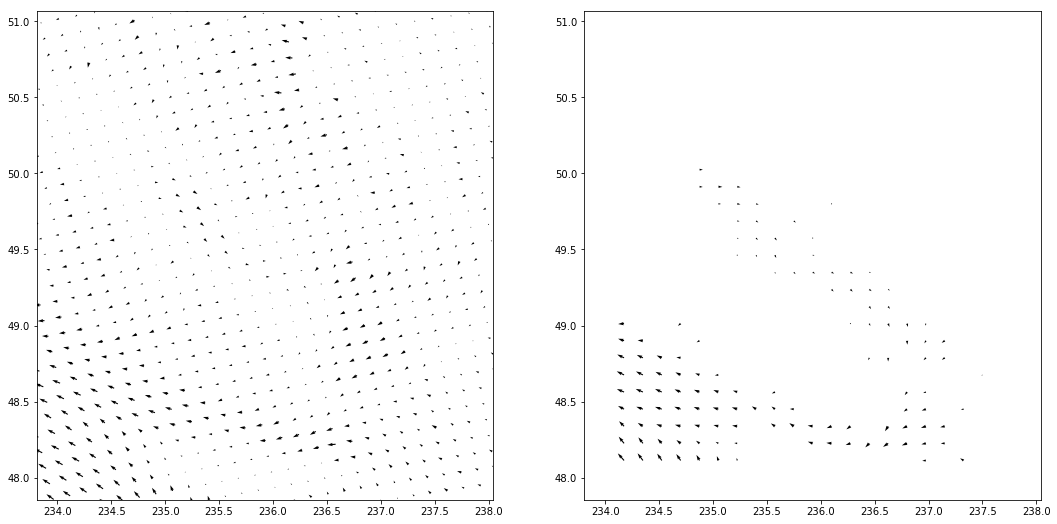

In [25]:
time = 0
fig, axs = plt.subplots(1, 2, figsize=(18, 9))
units = 'dots'
axs[0].quiver(
    hrdps.nav_lon[::5, ::5], hrdps.nav_lat[::5, ::5], 
    hrdps.u_wind[time][::5, ::5], hrdps.v_wind[time][::5, ::5],
    units=units, scale_units=units, scale=1,
)
axs[1].quiver(
    wwf.longitude[::25], wwf.latitude[::25],
    wwf.uwnd[time, ::25, ::25], wwf.vwnd[time, ::25, ::25],
    units=units, scale_units=units, scale=1,
)

axs[0].set_xlim(axs[1].get_xlim())
axs[0].set_ylim(axs[1].get_ylim())